## Random Forrest but with relative Data (Similar to Chen Paper)

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../Grunddatein/Zwischendatein/cleaned_data.csv')
## Exclude all Rows where condition isnt New and which where a reactive Crawl
df = df[df['trigByReactive'] != True]
df = df[df['condition'].isin(['Neu', 'New'])]

def calculate_price_diff_and_ratio(group):
    min_price = group['price'].min()
    group['price_diff'] = group['price'] - min_price
    group['price_ratio'] = group['price'] / min_price
    return group

grouped_df = df.groupby(['asin', 'time'],group_keys=True)
df = grouped_df.apply(calculate_price_diff_and_ratio)

# Create a new column 'is_amazon' and set its value to True if the sellerName is 'Amazon', else set it to False
df['is_amazon'] = df['sellerName'] == 'amazon'

# Count the number of rows where 'is_amazon' is True
amazon_count = df['is_amazon'].sum()
print(f"Number of rows sold by Amazon: {amazon_count}")


Number of rows sold by Amazon: 6848


In [3]:
## Encode Features with Label Encoding
##Lieferpreis
nan_rows = df[df['lieferpreis'].isna()]
amazon_count = nan_rows['sellerName'].str.contains('amazon', case=False).sum()
amazon_count
df['lieferpreis'] = df['lieferpreis'].fillna(0)
nan_rows = df[df['lieferpreis'].isna()]
print(f"Length of NAN Values for Lieferpreis: {len(nan_rows)}")
## Sellerbewertung
nan_rows = df[df['sellerbewertung'].isna()]
print(len(nan_rows))
amazon_count = nan_rows['sellerName'].str.contains('amazon', case=False).sum()
amazon_count

# Calculate the mean value of the "sellerbewertung" column
mean_sellerbewertung = df['sellerbewertung'].mean()
print(mean_sellerbewertung)

# Replace all NaN values in the "sellerbewertung" column with the mean value
df['sellerbewertung'] = df['sellerbewertung'].fillna(mean_sellerbewertung)
df['sellerbewertung'] = df['sellerbewertung'].round().astype(int)

Length of NAN Values for Lieferpreis: 0
7973
21418.24931189116


In [4]:
##Datediff
fba_rows = df[df['Fulfillment_type'] == 'FBA']
if fba_rows.empty:
    print('There are no rows where "Fulfillment_type" is "fba".')
else:
    # Calculate the mean value of the "date_diff" column where "fulfillment_type" is "fba"
    mean_date_diff_fba = fba_rows['date_diff'].mean()
    #print(f'The mean value of "date_diff" where "Fulfillment_type  " is "fba" is: {mean_date_diff_fba}')

# Round the mean value to the nearest integer
rounded_mean_date_diff_fba = round(mean_date_diff_fba)
# Replace all NaN values in the "date_diff" column with the rounded mean value
df['date_diff'] = df['date_diff'].fillna(rounded_mean_date_diff_fba).astype(int)

In [5]:
from sklearn.preprocessing import LabelEncoder
categorical_features = ['asin', 'sellerId', 'Fulfillment_type']

# Create a LabelEncoder object and fit it to each categorical feature
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

In [12]:
# Convert the datetime column to a numeric value
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df["time"] = df["time"].apply(lambda x: x.timestamp())

# Actual Random Forrest Classifier

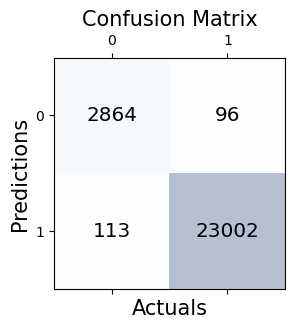

AUC: 0.9789430602436965


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

#Maybe its better to ignore the Column Sellerbewertung
#Testing without SellerID

#X = df[['asin','time', 'price','sellerbewertung','seller_sterne','lieferpreis','Fulfillment_type','date_diff','numberOfSellers']]
X = df[['price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','is_amazon','numberOfSellers']]
#X = df[['price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','is_amazon']]
y = df['buyBoxWinner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Create and train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)


# Calculate the confusion matrix
# The Printing of the confusion matrix, is partially buggy. Follow this Tutorial to retrive the right matrix:
##This Code is based on the Example from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Swap True Positives and True Negatives
conf_matrix[0,0], conf_matrix[1,1] = conf_matrix[1,1], conf_matrix[0,0]

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')

plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()


#Area under The Curve ausrechnen lassen
# Calculate the AUC
#The AUC (area under the ROC curve) is a measure of the performance of a binary classification model. 
#It represents the degree to which the model is able to distinguish between positive and negative examples. 
#The AUC ranges from 0 to 1, with higher values indicating better performance.
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

#Balanced ACC
#bal_acc = balanced_accuracy_score(y_test, y_pred)
#print("Balanced accuracy:", bal_acc)

In [14]:
num_true = (df['buyBoxWinner'] == True).sum()
num_true
print(f"The Number of Rows winning the BuyBox in the total Dataframe is {num_true}")
print(f"The Number of Rows winning the BuyBox in the Test-Set is {conf_matrix[0,0] + conf_matrix[1,0]}")

The Number of Rows winning the BuyBox in the total Dataframe is 9923
The Number of Rows winning the BuyBox in the Test-Set is 2977


In [15]:
value_counts = y_test.value_counts()
# print the result
print(value_counts)
# Count the number of rows in the train and test sets
num_rows_train = X_train.shape[0]
num_rows_test = X_test.shape[0]
# Print the results
print(f'The number of rows in the train set is: {num_rows_train}')
print(f'The number of rows in the test set is: {num_rows_test}')

False    23098
True      2977
Name: buyBoxWinner, dtype: int64
The number of rows in the train set is: 60839
The number of rows in the test set is: 26075


In [16]:
##Qualitätsmaße
# Calculate the accuracy, aber ansich nicht so gutes Maß, da imbalanced Verteilung von BuyBox
#Gewichtete Accuracy berechnen
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 99.20%
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     23098
        True       0.97      0.96      0.96      2977

    accuracy                           0.99     26075
   macro avg       0.98      0.98      0.98     26075
weighted avg       0.99      0.99      0.99     26075



In [17]:
## Print out Feature Importances
feature_importances = rfc.feature_importances_
feature_names = X.columns
# Create a DataFrame of the feature importances and their names
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances and their names
print(feature_importances_df)

            Feature  Importance
7         is_amazon    0.221173
2     seller_sterne    0.156991
1       price_ratio    0.132801
0        price_diff    0.113132
4  Fulfillment_type    0.098088
3   sellerbewertung    0.090301
8   numberOfSellers    0.084667
6         date_diff    0.051822
5       lieferpreis    0.051026


## Second Actual Random Forest with Seen and Unseen Data

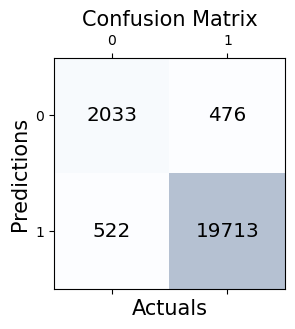

AUC: 0.88605876037008


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


# Get unique 'asin' values and split them into train and test sets
unique_asins = df['asin'].unique()
train_asins, test_asins = train_test_split(unique_asins, test_size=0.25, random_state=56)

# Split the DataFrame into seen (training) and unseen (testing) data based on the train and test 'asin' sets
seen_data = df[df['asin'].isin(train_asins)]
unseen_data = df[df['asin'].isin(test_asins)]

# Prepare the seen and unseen data for the model
X_train_seen = seen_data[['is_amazon','price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','numberOfSellers']]
y_train_seen = seen_data['buyBoxWinner']

X_test_unseen = unseen_data[['is_amazon','price_diff','price_ratio','seller_sterne','sellerbewertung','Fulfillment_type','lieferpreis','date_diff','numberOfSellers']]
y_test_unseen = unseen_data['buyBoxWinner']

# Your original code to train the model and evaluate it (unchanged)
# Create and train the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_seen, y_train_seen)

# Make predictions on the test set
y_pred = rfc.predict(X_test_unseen)


# Calculate the confusion matrix
# The Printing of the confusion matrix, is partially buggy. Follow this Tutorial to retrive the right matrix:
##This Code is based on the Example from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
conf_matrix = confusion_matrix(y_true=y_test_unseen, y_pred=y_pred)

# Swap True Positives and True Negatives
conf_matrix[0,0], conf_matrix[1,1] = conf_matrix[1,1], conf_matrix[0,0]

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')

plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()


#Area under The Curve ausrechnen lassen
# Calculate the AUC
#The AUC (area under the ROC curve) is a measure of the performance of a binary classification model. 
#It represents the degree to which the model is able to distinguish between positive and negative examples. 
#The AUC ranges from 0 to 1, with higher values indicating better performance.
auc = roc_auc_score(y_test_unseen, y_pred)
print("AUC:", auc)

#Balanced ACC
#bal_acc = balanced_accuracy_score(y_test, y_pred)
#print("Balanced accuracy:", bal_acc)

In [24]:
num_true = (df['buyBoxWinner'] == True).sum()
num_true
print(f"The Number of Rows winning the BuyBox in the total Dataframe is {num_true}")
print(f"The Number of Rows winning the BuyBox in the Test-Set is {conf_matrix[0,0] + conf_matrix[1,0]}")

The Number of Rows winning the BuyBox in the total Dataframe is 9923
The Number of Rows winning the BuyBox in the Test-Set is 2555


In [25]:
value_counts = y_test_unseen.value_counts()
# print the result
print(value_counts)
# Count the number of rows in the train and test sets
num_rows_train = X_train_seen.shape[0]
num_rows_test = X_test_unseen.shape[0]
# Print the results
print(f'The number of rows in the train set is: {num_rows_train}')
print(f'The number of rows in the test set is: {num_rows_test}')

False    20189
True      2555
Name: buyBoxWinner, dtype: int64
The number of rows in the train set is: 64170
The number of rows in the test set is: 22744


In [26]:
##Qualitätsmaße
# Calculate the accuracy, aber ansich nicht so gutes Maß, da imbalanced Verteilung von BuyBox
#Gewichtete Accuracy berechnen
acc = accuracy_score(y_test_unseen, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))
print("Classification Report:\n", classification_report(y_test_unseen, y_pred))


Accuracy: 95.61%
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.98     20189
        True       0.81      0.80      0.80      2555

    accuracy                           0.96     22744
   macro avg       0.89      0.89      0.89     22744
weighted avg       0.96      0.96      0.96     22744



In [27]:
## Print out Feature Importances
feature_importances = rfc.feature_importances_
feature_names = X_train_seen.columns
print(feature_names)
# Create a DataFrame of the feature importances and their names
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame of feature importances and their names
print(feature_importances_df)

Index(['is_amazon', 'price_diff', 'price_ratio', 'seller_sterne',
       'sellerbewertung', 'Fulfillment_type', 'lieferpreis', 'date_diff',
       'numberOfSellers'],
      dtype='object')
            Feature  Importance
0         is_amazon    0.211544
2       price_ratio    0.172460
3     seller_sterne    0.142686
1        price_diff    0.113654
8   numberOfSellers    0.089423
4   sellerbewertung    0.087693
5  Fulfillment_type    0.081635
6       lieferpreis    0.053121
7         date_diff    0.047784
